In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import geoip2.database

from scipy.stats import spearmanr
from scipy.stats import rankdata

In [2]:
files = [ "./data/cmds_sequence_2016-07-01.csv", "./data/cmds_sequence_2016-07-02.csv", "./data/cmds_sequence_2016-07-03.csv", "./data/cmds_sequence_2016-07-04.csv", 
    "./data/cmds_sequence_2016-07-05.csv", "./data/cmds_sequence_2016-07-06.csv", "./data/cmds_sequence_2016-07-07.csv", "./data/cmds_sequence_2016-07-08.csv", 
    "./data/cmds_sequence_2016-07-09.csv", "./data/cmds_sequence_2016-07-10.csv", "./data/cmds_sequence_2016-07-11.csv", "./data/cmds_sequence_2016-07-12.csv", 
    "./data/cmds_sequence_2016-07-13.csv", "./data/cmds_sequence_2016-07-14.csv", "./data/cmds_sequence_2016-07-15.csv", "./data/cmds_sequence_2016-07-16.csv", 
    "./data/cmds_sequence_2016-07-17.csv", "./data/cmds_sequence_2016-07-18.csv", "./data/cmds_sequence_2016-07-19.csv", "./data/cmds_sequence_2016-07-20.csv", 
    "./data/cmds_sequence_2016-07-21.csv", "./data/cmds_sequence_2016-07-22.csv", "./data/cmds_sequence_2016-07-23.csv", "./data/cmds_sequence_2016-07-24.csv", 
    "./data/cmds_sequence_2016-07-25.csv", "./data/cmds_sequence_2016-07-26.csv", "./data/cmds_sequence_2016-07-27.csv", "./data/cmds_sequence_2016-07-28.csv", 
    "./data/cmds_sequence_2016-07-29.csv", "./data/cmds_sequence_2016-07-30.csv", "./data/cmds_sequence_2016-07-31.csv", "./data/cmds_sequence_2016-08-29.csv", 
    "./data/cmds_sequence_2016-08-30.csv", "./data/cmds_sequence_2016-08-31.csv", "./data/cmds_sequence_2016-09-01.csv", "./data/cmds_sequence_2016-09-02.csv", 
    "./data/cmds_sequence_2016-09-03.csv", "./data/cmds_sequence_2016-09-04.csv", "./data/cmds_sequence_2016-09-05.csv", "./data/cmds_sequence_2016-09-06.csv", 
    "./data/cmds_sequence_2016-09-07.csv", "./data/cmds_sequence_2016-09-08.csv", "./data/cmds_sequence_2016-09-09.csv", "./data/cmds_sequence_2016-09-10.csv", 
    "./data/cmds_sequence_2016-09-11.csv", "./data/cmds_sequence_2016-09-12.csv", "./data/cmds_sequence_2016-09-13.csv"
]

# Read in IP geolocation database
reader = geoip2.database.Reader('./data/GeoLite2-Country.mmdb')

# create countrycode => # of IP addresses mapping
ip_mapping_df = pd.read_csv('./data/ip_addresses_country.csv')
ip_mapping = ip_mapping_df['IP addresses']
ip_mapping.index = ip_mapping_df['ISO country code']

# cyber security awareness data (1)
awareness_1 = pd.read_csv('./data/cyber_security_awareness.csv', index_col=0)

# cyber security awareness data (2)
awareness_2 = pd.read_csv('./data/NCSI_ega_ee.csv', index_col=0)

# Infrastructure data
infrastructure = pd.read_csv('./data/ranking_infrastructure.csv', index_col=0)

# Internet usage data
internet_usage = pd.read_csv('./data/internet_usage.csv', index_col=0)

# Internet speed data
internet_speed = pd.read_csv('./data/broadband_speed.csv', index_col=0)

def get_country_code(ip):
    try:
        return reader.country(ip).country.iso_code
    except geoip2.errors.AddressNotFoundError:
        return "Not in Database"
    

def read_data(path: str) -> pd.DataFrame:
    """ Reads csv at `path` into a pandas dataframe """
    df = pd.read_csv(path, 
                   sep="\$\$",
                   header=None, 
                   names=["Timestamp", "Src IP", "Src Port", "Dest IP", "Dest Port", "Commandlist"], 
                   index_col=False)
    df['Commandlist'] = df['Commandlist'].apply(parse_command_string)
    df['country'] = df['Src IP'].apply(get_country_code)
    return df

def login_attempts(data: pd.DataFrame) -> pd.Series:
    """ Returns amount of login attempts the honeypot got for a day """
    return len(data)

def parse_command_string(commandstring: str) -> list:
    """ Parses a commandstring from the dataset into a python list """
    # Remove square brackets and first/last apostrophe
    commandstring = commandstring[2:-2]
    
    # Split on ', '
    commandstring = commandstring.split(r"', '")
    
    return commandstring

def country_counts(data: pd.DataFrame) -> pd.Series:
    """ Return value counts of src IP countries """
    return data['country'].value_counts()

## Data Testing
Here we test whether all data is loaded in correctly

In [3]:
data = read_data(files[0])
print("Login attempts", login_attempts(data))

/home/jupyter/venv/lib/python3.7/site-packages/ipykernel_launcher.py:51: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


Login attempts 54857


In [4]:
get_country_code('130.89.161.239')  # Own campus IP, should return NL

'NL'

In [5]:
ip_mapping['NL']

46379784

In [6]:
awareness_1.head()

,country,score
ISO_code,,
GB,United Kingdom,0.931
US,United States of America,0.926
FR,France,0.918
LT,Lithuania,0.908
EE,Estonia,0.905


In [7]:
awareness_2.head()

,rank,score
ISO_code,,
CZ,1,90.91
EE,2,90.91
ES,3,98.61
GR,4,88.31
LT,5,88.31


In [8]:
infrastructure.head()

,country,rank,score
ISO_code,,,
SG,Singapore,1,"95,7"
HK,Hong Kong SAR,2,94
CH,Switzerland,3,"93,3"
NL,Netherlands,4,"92,4"
JP,Japan,5,"91,5"


In [9]:
internet_usage.head()

,country,score
ISO_code,,
QA,Qatar,99.652849
KW,Kuwait,99.599993
IS,Iceland,99.010954
BH,Bahrain,98.643429
AE,United Arab Emirates,98.450002


In [10]:
internet_speed.head()

,Country,rank
ISO_code,,
TW,Taiwan,1
SG,Singapore,2
JE,Jersey,3
SE,Sweden,4
DK,Denmark,5


## Data aggregation
Here we aggregate relevant data from our dataset

In [11]:
country_activity = {k: [] for k in ip_mapping.index.unique()}

for f in files:
    print("Reading file:", f)
    
    # Read data
    data = read_data(f)
    
    # Compute daily statistic for country
    cc = country_counts(data)
    
    # Append daily statistic to the right list.
    for country in country_activity.keys():
        if country in cc:
            country_activity[country].append(cc[country])
        else:
            country_activity[country].append(0)
    

Reading file: ./data/cmds_sequence_2016-07-01.csv


/home/jupyter/venv/lib/python3.7/site-packages/ipykernel_launcher.py:51: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


Reading file: ./data/cmds_sequence_2016-07-02.csv
Reading file: ./data/cmds_sequence_2016-07-03.csv
Reading file: ./data/cmds_sequence_2016-07-04.csv
Reading file: ./data/cmds_sequence_2016-07-05.csv
Reading file: ./data/cmds_sequence_2016-07-06.csv
Reading file: ./data/cmds_sequence_2016-07-07.csv
Reading file: ./data/cmds_sequence_2016-07-08.csv
Reading file: ./data/cmds_sequence_2016-07-09.csv
Reading file: ./data/cmds_sequence_2016-07-10.csv
Reading file: ./data/cmds_sequence_2016-07-11.csv
Reading file: ./data/cmds_sequence_2016-07-12.csv
Reading file: ./data/cmds_sequence_2016-07-13.csv
Reading file: ./data/cmds_sequence_2016-07-14.csv
Reading file: ./data/cmds_sequence_2016-07-15.csv
Reading file: ./data/cmds_sequence_2016-07-16.csv
Reading file: ./data/cmds_sequence_2016-07-17.csv
Reading file: ./data/cmds_sequence_2016-07-18.csv
Reading file: ./data/cmds_sequence_2016-07-19.csv
Reading file: ./data/cmds_sequence_2016-07-20.csv
Reading file: ./data/cmds_sequence_2016-07-21.csv


## Statistics
Here we will actually apply the statics, the spearman test, to the data

In [12]:
# Normalize the aggregated data
normalized = pd.Series()
for label, values in country_activity.items():
    if not pd.isnull(label) and label in ip_mapping and ip_mapping[label] != 0:
        divider = ip_mapping[label]
        normalized[label] = (sum(country_activity[label]) / divider)
normalized.head()

AF    0.019134
AX    0.000000
AL    0.010366
DZ    0.000599
AS    0.000000
dtype: float64

In [37]:
def plot_correlation(a: pd.Series, b: pd.Series, rho: float, p: float, title: str=""):
    fig = plt.figure(figsize=(15,10))
    plt.plot(np.arange(len(a)), a, label="Aggregated Data", marker="o")
    plt.plot(np.arange(len(b)), b, label=f"{title} Data", marker="x")
    plt.legend(loc='lower right')
    plt.xlabel("Countries")
    plt.ylabel("Rank")
    plt.title("{} - Correlation: {:.3e}; p-value: {:.3e}".format(title, rho, p))
    plt.tight_layout()
    plt.savefig(f"{title}_correlation_lines.png", dpi=400)
    plt.show()

def correlation(a: pd.Series, b: pd.Series, title: str="") -> (float, float):
    # Take only indexes that are in both series
    intersection = a.index.intersection(b.index)
    
    # Take the values that are in the intersection index
    a_intersec = a[intersection]
    b_intersec = b[intersection]
    
    # Rank both columns
    ranked_a = pd.Series(rankdata(a_intersec, method='average'), index=a_intersec.index)
    ranked_b = pd.Series(rankdata(b_intersec, method='average'), index=b_intersec.index)
    
    # Calculate spearman r and return the result
    rho, p = spearmanr(ranked_a, ranked_b)
    
    # Plot the correlation
    plot_correlation(ranked_a, ranked_b, rho, p, title)
    
    # Return the correlation and p-value
    return (rho, p)

Cyber security awareness data (1):


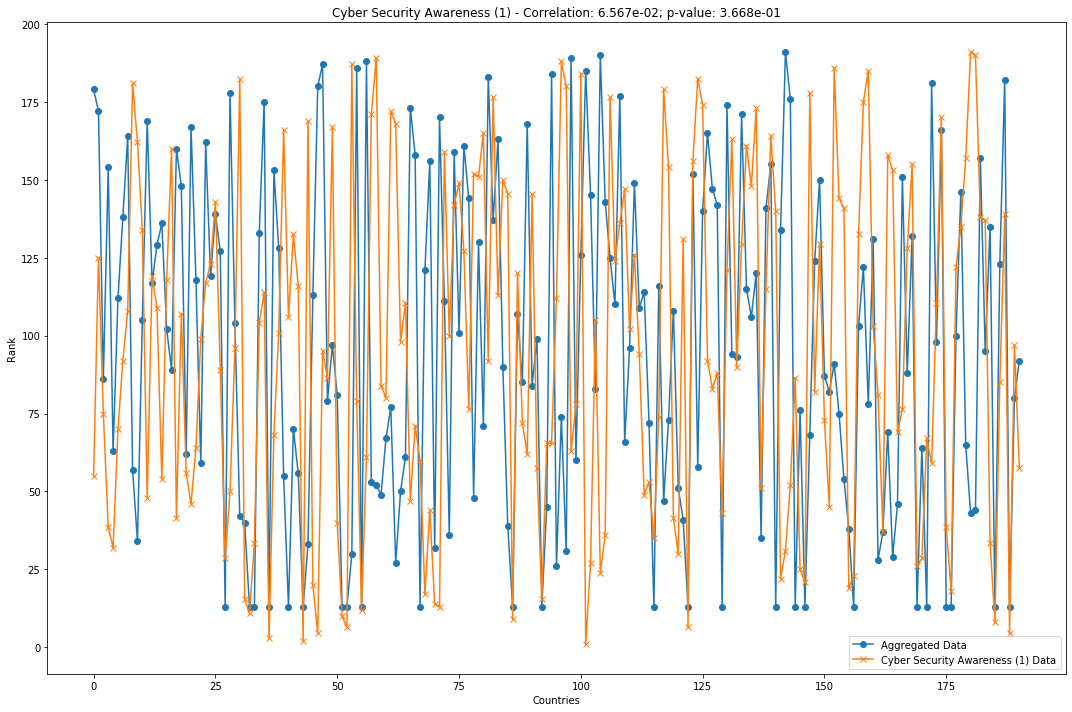

	correlation: 0.06566814650513475 
	p-value: 0.36675464120837

Cyber security awareness data (2):


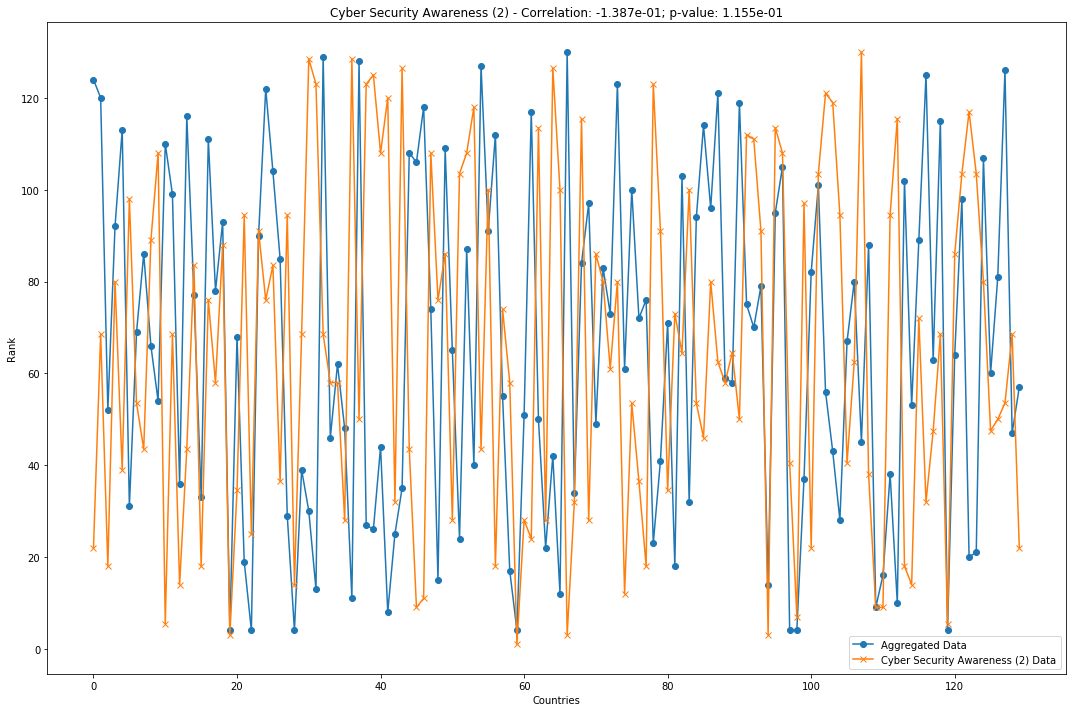

	correlation: -0.13871528245339665 
	p-value: 0.11550099414449268

Infrastructure data:


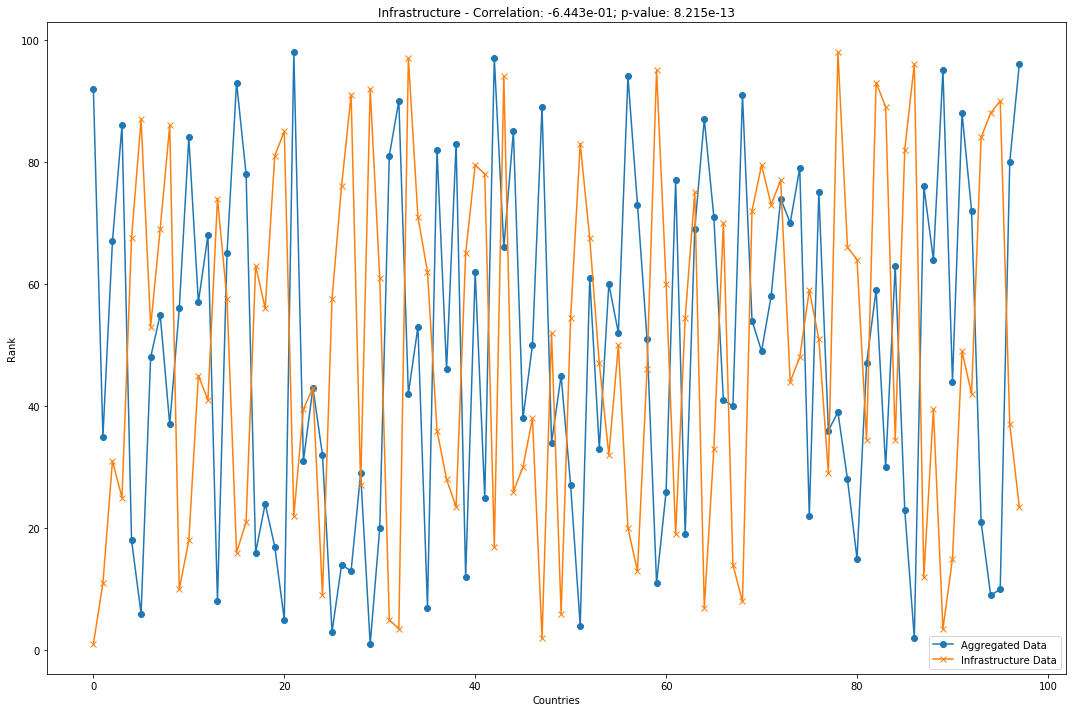

	correlation: -0.6442793843148457 
	p-value: 8.215298552681777e-13

Internet usage data:


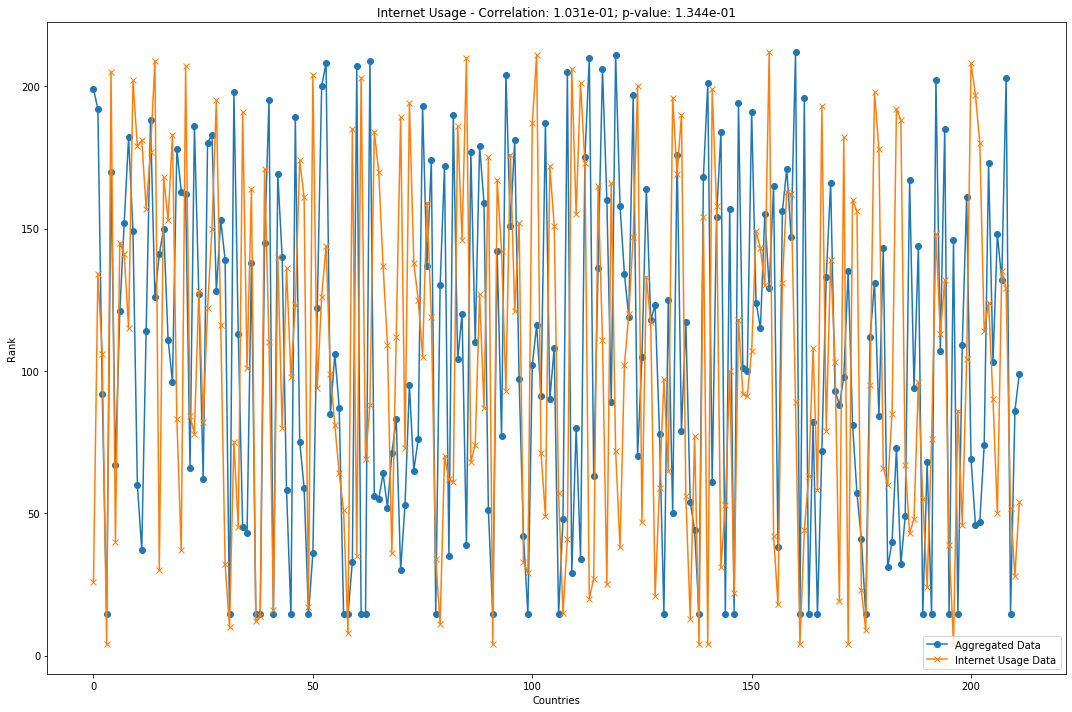

	correlation: 0.10314034920554883 
	p-value: 0.1344290985722506

Internet speed data:


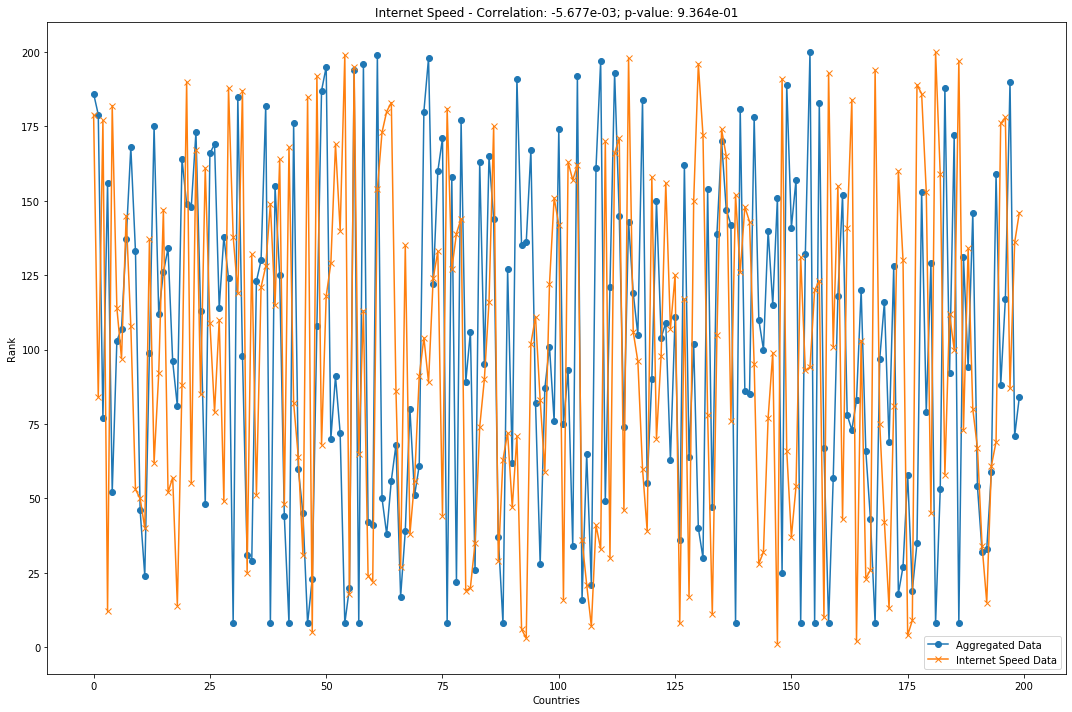

	correlation: -0.00567733429877486 
	p-value: 0.9364066523674865


In [38]:
# Calculate the spearman correlation coefficient for the aggregated data with all other data we gathered
print("Cyber security awareness data (1):")
print("\tcorrelation: {} \n\tp-value: {}".format(*correlation(normalized, awareness_1['score'], "Cyber Security Awareness (1)")))
print("")
print("Cyber security awareness data (2):")
print("\tcorrelation: {} \n\tp-value: {}".format(*correlation(normalized, awareness_2['score'], "Cyber Security Awareness (2)")))
print("")
print("Infrastructure data:")
print("\tcorrelation: {} \n\tp-value: {}".format(*correlation(normalized, infrastructure['score'], "Infrastructure")))
print("")
print("Internet usage data:")
print("\tcorrelation: {} \n\tp-value: {}".format(*correlation(normalized, internet_usage['score'], "Internet Usage")))
print("")
print("Internet speed data:")
print("\tcorrelation: {} \n\tp-value: {}".format(*correlation(normalized, internet_speed['rank'], "Internet Speed")))